Tests to implement:

1. KDD/GDD biases
2. LH/SH biases
3. Do these biases scale with ag production
4. Do these biases change over the growing season
5. Do historical cmip6 temperature biases predict future changes

In [45]:
import xarray as xr
import xesmf as xe
import numpy as np
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm
import cartopy
import cartopy.crs as ccrs
import glob
import sys
import datetime

In [46]:
run ../util/setupConsole_su

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
dirCmip6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/CMIP6'
dirERA5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Data-edcoffel-F20/ERA5'
dirDeepak = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate/deepak/Maize_yield_1970_2013'

In [48]:
cmip6_models = ['access-cm2', 'access-esm1-5', 'awi-cm-1-1-mr', 'bcc-csm2-mr', 'bcc-esm1', 'canesm5', 'ec-earth3', \
                'gfdl-cm4', 'gfdl-esm4', 'giss-e2-1-g', 'kace-1-0-g', 'fgoals-g3', 'inm-cm5-0', 'ipsl-cm6a-lr', 'miroc6', \
                'mpi-esm1-2-hr', 'mpi-esm1-2-lr', 'mri-esm2-0', 'noresm2-lm', 'noresm2-mm', 'sam0-unicon']

cmip6_txx_ds = xr.Dataset()
cmip6_t50p_ds = xr.Dataset()
cmip6_monthly_mean_tx_ds = xr.Dataset()

cmip6_txx_dict = {}
cmip6_txx_regrid_dict = {}
cmip6_t50p_dict = {}
cmip6_t50p_regrid_dict = {}

In [49]:
regridBuffer = 2
latRange = [20, 55]
lonRange = [220, 300]

regridMesh = xr.Dataset({'lat': (['lat'], np.arange(latRange[0], latRange[1], 1.5)),
                         'lon': (['lon'], np.arange(lonRange[0], lonRange[1], 1.5)),})

In [50]:
for i, model in enumerate(cmip6_models):
    print('opening %s...'%model)
    cmip6_tasmax_hist = xr.open_mfdataset('%s/%s/r1i1p1f1/historical/tasmax/*.nc'%(dirCmip6, model), concat_dim='time')
    print('selecting data for %s...'%model)
    cmip6_tasmax_hist_us = cmip6_tasmax_hist.sel(lat=slice(latRange[0], latRange[1]), \
                                     lon=slice(lonRange[0], lonRange[1]), \
                                     time=slice('1979-01', '2014-12'))
    print('resampling %s...'%model)
    cmip6_txx_hist_us = cmip6_tasmax_hist_us.resample(time='1Y').max()
    cmip6_t50p_hist_us = cmip6_tasmax_hist_us.resample(time='1Y').median()
    cmip6_monthly_mean_tx_hist_us = cmip6_tasmax_hist_us.groupby('time.month').mean()
    
    cmip6_txx_hist_us['tasmax'] -= 273.15
    cmip6_t50p_hist_us['tasmax'] -= 273.15
    cmip6_monthly_mean_tx_hist_us['tasmax'] -= 273.15
    
    print('loading %s...'%model)
    cmip6_txx_hist_us.load()
    cmip6_t50p_hist_us.load()
    cmip6_monthly_mean_tx_hist_us.load()
    
    print('regridding %s...'%model)
    regridder = xe.Regridder(cmip6_txx_hist_us, regridMesh, 'bilinear')
    regridder.clean_weight_file()
    cmip6_txx_hist_us_regrid = regridder(cmip6_txx_hist_us.tasmax)
    cmip6_t50p_hist_us_regrid = regridder(cmip6_t50p_hist_us.tasmax)
    cmip6_monthly_mean_tx_hist_us_regrid = regridder(cmip6_monthly_mean_tx_hist_us.tasmax)
    
    if i == 0:
        timeVar = cmip6_txx_hist_us.time
    
    tempDs_txx = xr.DataArray(data   = cmip6_txx_hist_us_regrid, 
                          dims   = ['time', 'lat', 'lon'],
                          coords = {'time': timeVar, 'lat':regridMesh['lat'], 'lon':regridMesh['lon']},
                          attrs  = {'units'     : 'C'
                            })
    cmip6_txx_ds['txx_%s'%model] = tempDs_txx
    
    tempDs_t50p = xr.DataArray(data   = cmip6_t50p_hist_us_regrid, 
                          dims   = ['time', 'lat', 'lon'],
                          coords = {'time': timeVar, 'lat':regridMesh['lat'], 'lon':regridMesh['lon']},
                          attrs  = {'units'     : 'C'
                            })
    cmip6_t50p_ds['t50p_%s'%model] = tempDs_t50p
    
    tempDs_monthly_mean_tx = xr.DataArray(data = cmip6_monthly_mean_tx_hist_us_regrid, 
                          dims   = ['month', 'lat', 'lon'],
                          coords = {'month': cmip6_monthly_mean_tx_hist_us.month, 'lat':regridMesh['lat'], 'lon':regridMesh['lon']},
                          attrs  = {'units'     : 'C'
                            })
    cmip6_monthly_mean_tx_ds['monthly_mean_tx_%s'%model] = tempDs_monthly_mean_tx
    
    print()
cmip6_txx_ds.to_netcdf('cmip6_txx_us.nc')
cmip6_t50p_ds.to_netcdf('cmip6_t50p_us.nc')
cmip6_monthly_mean_tx_ds.to_netcdf('cmip6_monthly_mean_tx_us.nc')

opening access-cm2...
selecting data for access-cm2...
resampling access-cm2...
loading access-cm2...
regridding access-cm2...
Create weight file: bilinear_28x43_24x54.nc
Remove file bilinear_28x43_24x54.nc

opening access-esm1-5...
selecting data for access-esm1-5...
resampling access-esm1-5...
loading access-esm1-5...
regridding access-esm1-5...
Create weight file: bilinear_29x43_24x54.nc
Remove file bilinear_29x43_24x54.nc

opening awi-cm-1-1-mr...
selecting data for awi-cm-1-1-mr...
resampling awi-cm-1-1-mr...
loading awi-cm-1-1-mr...
regridding awi-cm-1-1-mr...
Create weight file: bilinear_38x86_24x54.nc
Remove file bilinear_38x86_24x54.nc

opening bcc-csm2-mr...
selecting data for bcc-csm2-mr...
resampling bcc-csm2-mr...
loading bcc-csm2-mr...
regridding bcc-csm2-mr...
Create weight file: bilinear_31x71_24x54.nc
Remove file bilinear_31x71_24x54.nc

opening bcc-esm1...
selecting data for bcc-esm1...
resampling bcc-esm1...
loading bcc-esm1...
regridding bcc-esm1...
Create weight fi

PermissionError: [Errno 13] Permission denied: b'/smb/shared/4d8d5d/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/2020-ag-cmip6/cmip6_txx_us.nc'

In [31]:
cmip6_txx_ds = xr.open_dataset('cmip6_txx_us.nc')
cmip6_t50p_ds = xr.open_dataset('cmip6_t50p_us.nc')
cmip6_monthly_mean_tx_ds = xr.open_dataset('cmip6_monthly_mean_tx_us.nc')

In [32]:
cmip6_txx_trend = xr.Dataset()
cmip6_t50p_trend = xr.Dataset()

for model in cmip6_models:
    print('calc trends for %s...'%model)
    tmpTxxTrend = np.full([cmip6_txx_ds.lat.values.shape[0], cmip6_txx_ds.lon.values.shape[0]], np.nan)
    tmpT50pTrend = np.full([cmip6_txx_ds.lat.values.shape[0], cmip6_txx_ds.lon.values.shape[0]], np.nan)
    
    for xlat in range(tmpTxxTrend.shape[0]):
        for ylon in range(tmpTxxTrend.shape[1]):
            curTxx = cmip6_txx_ds['txx_%s'%model].values[:, xlat, ylon]
            X = sm.add_constant(range(1979, 2015))
            mdl = sm.OLS(curTxx, X).fit()
            tmpTxxTrend[xlat, ylon] = mdl.params[1]*10
            
            curT50p = cmip6_t50p_ds['t50p_%s'%model].values[:, xlat, ylon]
            X = sm.add_constant(range(1979, 2015))
            mdl = sm.OLS(curT50p, X).fit()
            tmpT50pTrend[xlat, ylon] = mdl.params[1]*10

    tmpDs_txx = xr.DataArray(data   = tmpTxxTrend, 
                      dims   = ['lat', 'lon'],
                      coords = {'lat':cmip6_txx_ds.lat, 'lon':cmip6_txx_ds.lon},
                      attrs  = {'units'     : 'C'
                        })
    tmpDs_t50p = xr.DataArray(data   = tmpT50pTrend, 
                      dims   = ['lat', 'lon'],
                      coords = {'lat':cmip6_t50p_ds.lat, 'lon':cmip6_t50p_ds.lon},
                      attrs  = {'units'     : 'C'
                        })

    cmip6_txx_trend['txx_trend_%s'%model] = tmpDs_txx
    cmip6_t50p_trend['t50p_trend_%s'%model] = tmpDs_t50p

calc trends for access-cm2...
calc trends for access-esm1-5...
calc trends for awi-cm-1-1-mr...
calc trends for bcc-csm2-mr...
calc trends for bcc-esm1...
calc trends for canesm5...
calc trends for ec-earth3...
calc trends for gfdl-cm4...
calc trends for gfdl-esm4...
calc trends for giss-e2-1-g...
calc trends for kace-1-0-g...
calc trends for fgoals-g3...
calc trends for inm-cm5-0...
calc trends for ipsl-cm6a-lr...
calc trends for miroc6...
calc trends for mpi-esm1-2-hr...
calc trends for mpi-esm1-2-lr...
calc trends for mri-esm2-0...
calc trends for noresm2-lm...
calc trends for noresm2-mm...
calc trends for sam0-unicon...


In [65]:
cmip6_txx_trend_median = np.full([cmip6_txx_trend.lat.shape[0], cmip6_txx_trend.lon.shape[0], len(cmip6_models)], np.nan)
for i, model in enumerate(cmip6_models):
    cmip6_txx_trend_median[:,:,i] = cmip6_txx_trend['txx_trend_%s'%model].values
cmip6_txx_trend_median = np.nanmedian(cmip6_txx_trend_median,axis=2)

cmip6_t50p_trend_median = np.full([cmip6_t50p_trend.lat.shape[0], cmip6_t50p_trend.lon.shape[0], len(cmip6_models)], np.nan)
for i, model in enumerate(cmip6_models):
    cmip6_t50p_trend_median[:,:,i] = cmip6_t50p_trend['t50p_trend_%s'%model].values
cmip6_t50p_trend_median = np.nanmedian(cmip6_t50p_trend_median,axis=2)

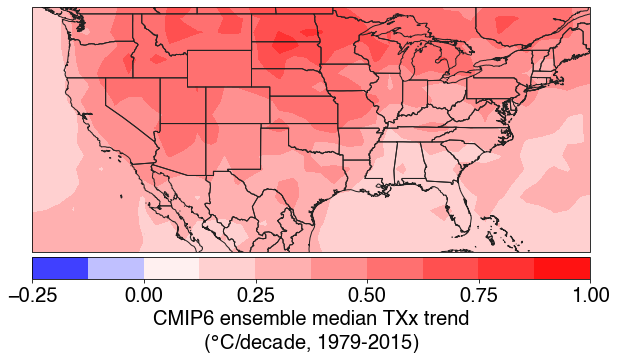

In [66]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -67, 23, 46])

v1 = -.25
v2 = 1.01
vstep = .125
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(cmip6_txx_trend.lon, cmip6_txx_trend.lat, cmip6_txx_trend_median, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
# plt.contourf(lon, lat, gddTrendSig, levels=[0, 0.05], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('CMIP6 ensemble median TXx trend\n($\degree$C/decade, 1979-2015)', fontsize=20)

# if wxData == 'gldas':
#     plt.savefig('obs-gdd-trend-cpc.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)
# elif wxData == 'era5':
#     plt.savefig('obs-gdd-trend-era5.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

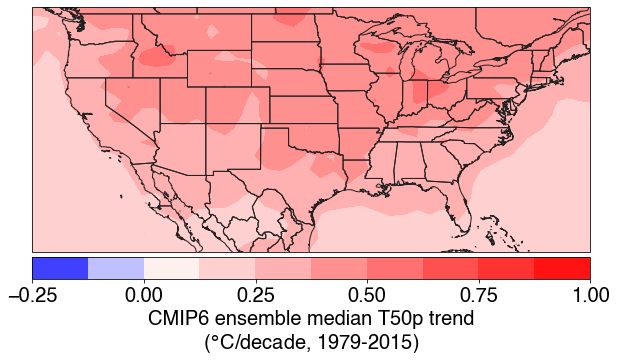

In [67]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -67, 23, 46])

v1 = -.25
v2 = 1.01
vstep = .125
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(cmip6_t50p_trend.lon, cmip6_t50p_trend.lat, cmip6_t50p_trend_median, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
# plt.contourf(lon, lat, gddTrendSig, levels=[0, 0.05], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('CMIP6 ensemble median T50p trend\n($\degree$C/decade, 1979-2015)', fontsize=20)

# if wxData == 'gldas':
#     plt.savefig('obs-gdd-trend-cpc.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)
# elif wxData == 'era5':
#     plt.savefig('obs-gdd-trend-era5.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [26]:
era5_txx = xr.Dataset()
era5_t50p = xr.Dataset()

for y, year in enumerate(range(1979, 2014+1)):
    print('processing era5 %d...'%year)
    tasmax_era5 = xr.open_dataset('%s/daily/tasmax_%d.nc'%(dirERA5, year))
    tasmax_era5_us = tasmax_era5.sel(latitude=slice(latRange[1], latRange[0]), \
                                     longitude=slice(lonRange[0], lonRange[1]))
    
    txx_era5_us = tasmax_era5_us.max(dim='time')
    txx_era5_us['mx2t'] -= 273.15
    
    t50p_era5_us = tasmax_era5_us.median(dim='time')
    t50p_era5_us['mx2t'] -= 273.15
    
    monthly_mean_tx_era5_us = tasmax_era5_us.groupby('time.month').mean()
    monthly_mean_tx_era5_us['mx2t'] -= 273.15
    
    txx_era5_us = txx_era5_us.rename_dims(latitude='lat', longitude='lon')
    txx_era5_us.load()
    
    t50p_era5_us = t50p_era5_us.rename_dims(latitude='lat', longitude='lon')
    t50p_era5_us.load()
    
    monthly_mean_tx_era5_us = monthly_mean_tx_era5_us.rename_dims(latitude='lat', longitude='lon')
    monthly_mean_tx_era5_us.load()
    
    regridder = xe.Regridder(txx_era5_us, regridMesh, 'bilinear')
    regridder.clean_weight_file()
    txx_era5_us_regrid = regridder(txx_era5_us.mx2t)
    t50p_era5_us_regrid = regridder(t50p_era5_us.mx2t)
    monthly_mean_tx_era5_us_regrid = regridder(monthly_mean_tx_era5_us.mx2t)
    
    tmpData_txx = np.full([1,txx_era5_us_regrid.values.shape[0], txx_era5_us_regrid.values.shape[1]], np.nan)
    tmpData_txx[0,:,:] = txx_era5_us_regrid.values
    
    tmpData_t50p = np.full([1,t50p_era5_us_regrid.values.shape[0], t50p_era5_us_regrid.values.shape[1]], np.nan)
    tmpData_t50p[0,:,:] = t50p_era5_us_regrid.values
    
    tmpData_monthly_mean_tx = np.full([1, monthly_mean_tx_era5_us_regrid.values.shape[1], monthly_mean_tx_era5_us_regrid.values.shape[2]], np.nan)
    tmpData_monthly_mean_tx[0,:,:] = monthly_mean_tx_era5_us_regrid.values
    
    tempDs_txx = xr.Dataset()
    tempDs_txx['era5_txx'] = xr.DataArray(data   = tmpData_txx, 
                          dims   = ['time', 'lat', 'lon'],
                          coords = {'time':[datetime.datetime(year,1,1)], 'lat':regridMesh['lat'], 'lon':regridMesh['lon']},
                          attrs  = {'units'     : 'C'
                            })
    
    tempDs_t50p = xr.Dataset()
    tempDs_t50p['era5_t50p'] = xr.DataArray(data   = tmpData_t50p, 
                          dims   = ['time', 'lat', 'lon'],
                          coords = {'time':[datetime.datetime(year,1,1)], 'lat':regridMesh['lat'], 'lon':regridMesh['lon']},
                          attrs  = {'units'     : 'C'
                            })
    
    tempDs_monthly_mean_tx = xr.Dataset()
    tempDs_monthly_mean_tx['era5_monthly_mean_tx'] = xr.DataArray(data   = tmpData_monthly_mean_tx, 
                          dims   = ['time', 'lat', 'lon'],
                          coords = {'time':[datetime.datetime(year,1,1)], 'lat':regridMesh['lat'], 'lon':regridMesh['lon']},
                          attrs  = {'units'     : 'C'
                            })
    
    if y == 0:
        era5_txx = tempDs_txx
        era5_t50p = tempDs_t50p
    else:
        era5_txx = xr.concat([era5_txx, tempDs_txx], dim='time')
        era5_t50p = xr.concat([era5_t50p, tempDs_t50p], dim='time')    
era5_txx.to_netcdf('era5_txx.nc')
era5_t50p.to_netcdf('era5_t50p.nc')

processing era5 1979...
Create weight file: bilinear_141x321_24x54.nc
Remove file bilinear_141x321_24x54.nc


ValueError: could not broadcast input array from shape (12,24,54) into shape (12,12,24)

In [27]:
monthly_mean_tx_era5_us_regrid.values.shape

(12, 24, 54)

In [69]:
# calc era5 txx and t50p trends
era5_txx = xr.open_dataset('era5_txx.nc')
era5_txx_trend = xr.Dataset()

era5_t50p = xr.open_dataset('era5_t50p.nc')
era5_t50p_trend = xr.Dataset()

print('calc era5 txx and t50p trends')
tmpTxxTrend = np.full([era5_txx.lat.values.shape[0], era5_txx.lon.values.shape[0]], np.nan)
tmpT50pTrend = np.full([era5_t50p.lat.values.shape[0], era5_t50p.lon.values.shape[0]], np.nan)

for xlat in range(tmpTxxTrend.shape[0]):
    for ylon in range(tmpTxxTrend.shape[1]):
        curTxx = era5_txx.era5_txx.values[:, xlat, ylon]
        X = sm.add_constant(range(1979, 2014+1))
        mdl = sm.OLS(curTxx, X).fit()
        tmpTxxTrend[xlat, ylon] = mdl.params[1]*10
        
        curT50p = era5_t50p.era5_t50p.values[:, xlat, ylon]
        X = sm.add_constant(range(1979, 2014+1))
        mdl = sm.OLS(curT50p, X).fit()
        tmpT50pTrend[xlat, ylon] = mdl.params[1]*10

era5_txx_trend['txx_trend'] = xr.DataArray(data   = tmpTxxTrend, 
                  dims   = ['lat', 'lon'],
                  coords = {'lat':era5_txx.lat, 'lon':era5_txx.lon},
                  attrs  = {'units'     : 'C'
                    })

era5_t50p_trend['t50p_trend'] = xr.DataArray(data   = tmpT50pTrend, 
                  dims   = ['lat', 'lon'],
                  coords = {'lat':era5_t50p.lat, 'lon':era5_t50p.lon},
                  attrs  = {'units'     : 'C'
                    })


calc era5 txx and t50p trends


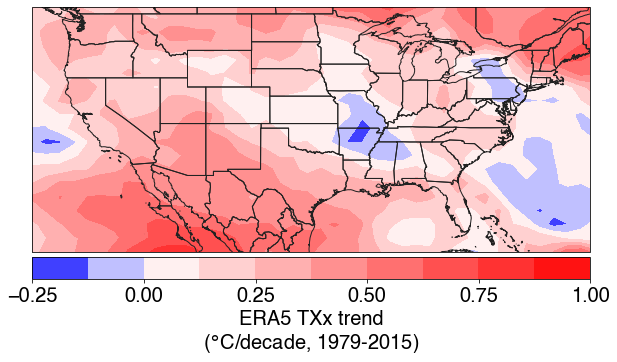

In [70]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -67, 23, 46])

v1 = -.25
v2 = 1.01
vstep = .125
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(era5_txx_trend.lon, era5_txx_trend.lat, era5_txx_trend.txx_trend.values, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
# plt.contourf(lon, lat, gddTrendSig, levels=[0, 0.05], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('ERA5 TXx trend\n($\degree$C/decade, 1979-2015)', fontsize=20)

# if wxData == 'gldas':
#     plt.savefig('obs-gdd-trend-cpc.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)
# elif wxData == 'era5':
#     plt.savefig('obs-gdd-trend-era5.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

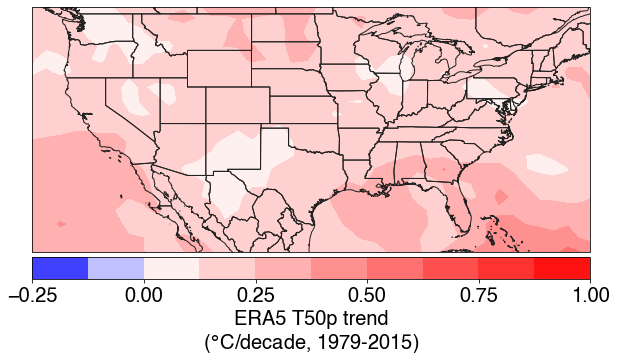

In [71]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -67, 23, 46])

v1 = -.25
v2 = 1.01
vstep = .125
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(era5_t50p_trend.lon, era5_t50p_trend.lat, era5_t50p_trend.t50p_trend.values, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
# plt.contourf(lon, lat, gddTrendSig, levels=[0, 0.05], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('ERA5 T50p trend\n($\degree$C/decade, 1979-2015)', fontsize=20)

# if wxData == 'gldas':
#     plt.savefig('obs-gdd-trend-cpc.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)
# elif wxData == 'era5':
#     plt.savefig('obs-gdd-trend-era5.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [72]:
# calculate trend bias between cmip6 and era5

cmip6_era5_txx_trend_bias_sig = np.full(era5_txx_trend.txx_trend.shape, np.nan)
cmip6_era5_txx_trend_bias = np.full([era5_txx_trend.txx_trend.shape[0], era5_txx_trend.txx_trend.shape[1], len(cmip6_models)], np.nan)
for m, model in enumerate(cmip6_models):
    cmip6_era5_txx_trend_bias[:,:,m] = cmip6_txx_trend['txx_trend_%s'%model].values - era5_txx_trend.txx_trend.values

for xlat in range(cmip6_era5_txx_trend_bias_sig.shape[0]):
    for ylon in range(cmip6_era5_txx_trend_bias_sig.shape[1]):
        t, p = scipy.stats.ttest_1samp(cmip6_era5_txx_trend_bias[xlat, ylon, :], 0)
        cmip6_era5_txx_trend_bias_sig[xlat, ylon] = p

        
cmip6_era5_t50p_trend_bias_sig = np.full(era5_t50p_trend.t50p_trend.shape, np.nan)
cmip6_era5_t50p_trend_bias = np.full([era5_t50p_trend.t50p_trend.shape[0], era5_t50p_trend.t50p_trend.shape[1], len(cmip6_models)], np.nan)
for m, model in enumerate(cmip6_models):
    cmip6_era5_t50p_trend_bias[:,:,m] = cmip6_t50p_trend['t50p_trend_%s'%model].values - era5_t50p_trend.t50p_trend.values

for xlat in range(cmip6_era5_t50p_trend_bias_sig.shape[0]):
    for ylon in range(cmip6_era5_t50p_trend_bias_sig.shape[1]):
        t, p = scipy.stats.ttest_1samp(cmip6_era5_t50p_trend_bias[xlat, ylon, :], 0)
        cmip6_era5_t50p_trend_bias_sig[xlat, ylon] = p

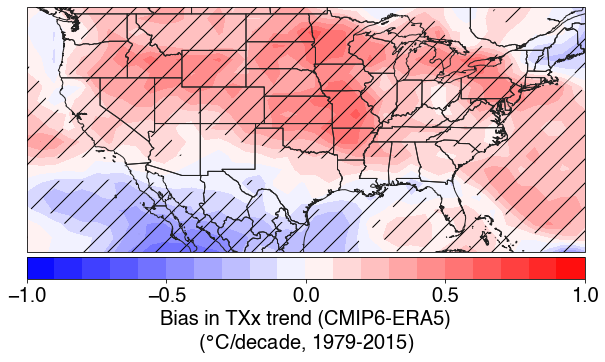

In [89]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -67, 23, 46])

v1 = -1
v2 = 1.01
vstep = .1
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(era5_txx_trend.lon, era5_txx_trend.lat, np.nanmedian(cmip6_era5_txx_trend_bias, axis=2), cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
plt.contourf(era5_txx_trend.lon, era5_txx_trend.lat, cmip6_era5_txx_trend_bias_sig, levels=[0, 0.05], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Bias in TXx trend (CMIP6-ERA5)\n($\degree$C/decade, 1979-2015)', fontsize=20)

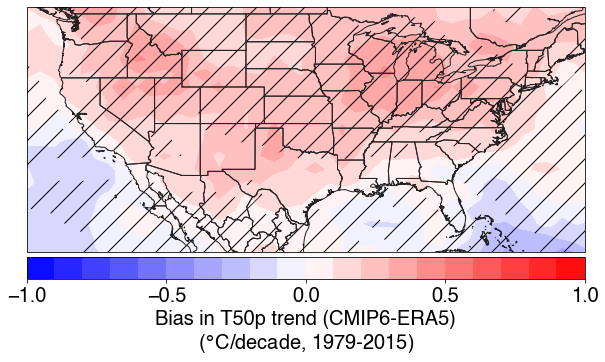

In [90]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -67, 23, 46])

v1 = -1
v2 = 1.01
vstep = .1
vlabelstep = .5

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(era5_t50p_trend.lon, era5_t50p_trend.lat, np.nanmedian(cmip6_era5_t50p_trend_bias, axis=2), cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
plt.contourf(era5_txx_trend.lon, era5_txx_trend.lat, cmip6_era5_txx_trend_bias_sig, levels=[0, 0.05], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Bias in T50p trend (CMIP6-ERA5)\n($\degree$C/decade, 1979-2015)', fontsize=20)

In [75]:
# calc bias by year

yearly_txx_bias = np.full([era5_txx.lat.values.shape[0], era5_txx.lon.values.shape[0], era5_txx.time.values.shape[0], len(cmip6_models)], np.nan)
yearly_t50p_bias = np.full([era5_t50p.lat.values.shape[0], era5_t50p.lon.values.shape[0], era5_t50p.time.values.shape[0], len(cmip6_models)], np.nan)

for i, model in enumerate(cmip6_models):
    print('processing %s...'%model)
    for y, year in enumerate(range(1979, 2014+1)):
        for xlat in range(yearly_txx_bias.shape[0]):
            for ylon in range(yearly_txx_bias.shape[1]):
                yearly_txx_bias[xlat, ylon, y, i] = cmip6_txx_ds['txx_%s'%model].values[y, xlat, ylon] - era5_txx.era5_txx.values[y, xlat, ylon]
                yearly_t50p_bias[xlat, ylon, y, i] = cmip6_t50p_ds['t50p_%s'%model].values[y, xlat, ylon] - era5_t50p.era5_t50p.values[y, xlat, ylon]
                

processing access-cm2...
processing access-esm1-5...
processing awi-cm-1-1-mr...
processing bcc-csm2-mr...
processing bcc-esm1...
processing canesm5...
processing ec-earth3...
processing gfdl-cm4...
processing gfdl-esm4...
processing giss-e2-1-g...
processing kace-1-0-g...
processing fgoals-g3...
processing inm-cm5-0...
processing ipsl-cm6a-lr...
processing miroc6...
processing mpi-esm1-2-hr...
processing mpi-esm1-2-lr...
processing mri-esm2-0...
processing noresm2-lm...
processing noresm2-mm...
processing sam0-unicon...


In [76]:
latInd = np.where((era5_txx.lat.values >= 41.5) & (era5_txx.lat.values <= 48))[0]
lonInd = np.where((era5_txx.lon.values >= 263) & (era5_txx.lon.values <= 270))[0]

yearly_txx_bias_midwest = yearly_txx_bias[latInd, :, :, :]
yearly_txx_bias_midwest = np.nanmean(np.nanmean(yearly_txx_bias_midwest[:, lonInd, :, :], axis=1), axis=0)

yearly_t50p_bias_midwest = yearly_t50p_bias[latInd, :, :, :]
yearly_t50p_bias_midwest = np.nanmean(np.nanmean(yearly_t50p_bias_midwest[:, lonInd, :, :], axis=1), axis=0)
# plt.plot(np.nanmedian(yearly_txx_bias_midwest, axis=1))

In [77]:
X = sm.add_constant(range(1979, 2015))
mdl = sm.RLM(np.nanmedian(yearly_txx_bias_midwest, axis=1), X).fit()
print('txx: coef = %.2f, p = %.2f'%(mdl.params[1], mdl.pvalues[1]))

X = sm.add_constant(range(1979, 2015))
mdl = sm.RLM(np.nanmedian(yearly_t50p_bias_midwest, axis=1), X).fit()
print('t50p: coef = %.2f, p = %.2f'%(mdl.params[1], mdl.pvalues[1]))

txx: coef = 0.06, p = 0.07
t50p: coef = 0.03, p = 0.04


In [78]:
for m in range(len(cmip6_models)):
    X = sm.add_constant(range(1979, 2015))
    mdl = sm.RLM(yearly_txx_bias_midwest[:,m], X).fit()
    print('coef = %.2f, p = %.2f'%(mdl.params[1], mdl.pvalues[1]))

coef = 0.04, p = 0.38
coef = 0.06, p = 0.22
coef = 0.06, p = 0.13
coef = 0.03, p = 0.36
coef = 0.04, p = 0.50
coef = 0.02, p = 0.71
coef = 0.06, p = 0.16
coef = 0.06, p = 0.11
coef = 0.05, p = 0.22
coef = -0.02, p = 0.51
coef = 0.02, p = 0.57
coef = 0.06, p = 0.17
coef = -0.03, p = 0.45
coef = 0.09, p = 0.02
coef = 0.06, p = 0.10
coef = -0.00, p = 0.91
coef = -0.01, p = 0.79
coef = 0.01, p = 0.88
coef = 0.05, p = 0.20
coef = 0.08, p = 0.02
coef = 0.08, p = 0.11


In [79]:
yearly_txx_bias_trend = np.full([yearly_txx_bias.shape[0], yearly_txx_bias.shape[1]], np.nan)
yearly_txx_bias_trend_sig = np.full([yearly_txx_bias.shape[0], yearly_txx_bias.shape[1]], np.nan)

yearly_t50p_bias_trend = np.full([yearly_t50p_bias.shape[0], yearly_t50p_bias.shape[1]], np.nan)
yearly_t50p_bias_trend_sig = np.full([yearly_t50p_bias.shape[0], yearly_t50p_bias.shape[1]], np.nan)

for xlat in range(yearly_txx_bias.shape[0]):
    for ylon in range(yearly_txx_bias.shape[1]):
        curBias = np.nanmedian(np.squeeze(yearly_txx_bias[xlat, ylon, :, :]), axis=1)
        X = sm.add_constant(range(1979, 2015))
        mdl = sm.RLM(curBias, X).fit()
        yearly_txx_bias_trend[xlat, ylon] = mdl.params[1]*10
        yearly_txx_bias_trend_sig[xlat, ylon] = mdl.pvalues[1]
        
        curBias = np.nanmedian(np.squeeze(yearly_t50p_bias[xlat, ylon, :, :]), axis=1)
        X = sm.add_constant(range(1979, 2015))
        mdl = sm.RLM(curBias, X).fit()
        yearly_t50p_bias_trend[xlat, ylon] = mdl.params[1]*10
        yearly_t50p_bias_trend_sig[xlat, ylon] = mdl.pvalues[1]

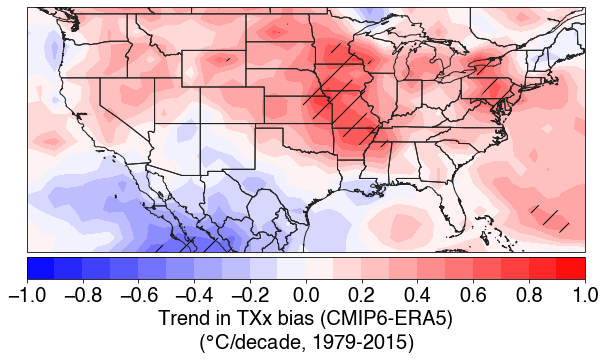

In [80]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -67, 23, 46])

v1 = -1
v2 = 1.01
vstep = .1
vlabelstep = .2

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(era5_txx_trend.lon, era5_txx_trend.lat, yearly_txx_bias_trend, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
plt.contourf(era5_txx_trend.lon, era5_txx_trend.lat, yearly_txx_bias_trend_sig, levels=[0, 0.1], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Trend in TXx bias (CMIP6-ERA5)\n($\degree$C/decade, 1979-2015)', fontsize=20)

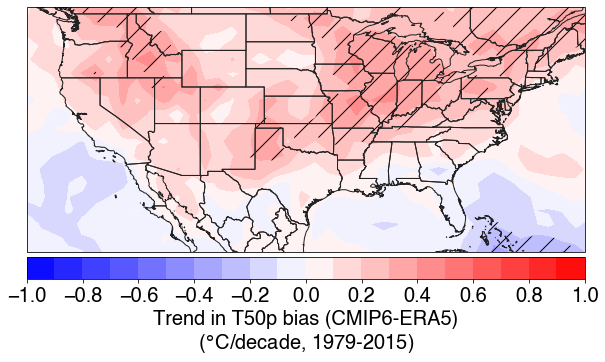

In [81]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -67, 23, 46])

v1 = -1
v2 = 1.01
vstep = .1
vlabelstep = .2

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('bwr')
c = plt.contourf(era5_t50p_trend.lon, era5_t50p_trend.lat, yearly_t50p_bias_trend, cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
plt.contourf(era5_t50p_trend.lon, era5_t50p_trend.lat, yearly_t50p_bias_trend_sig, levels=[0, 0.1], colors='none', hatches=['/', ''])
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Trend in T50p bias (CMIP6-ERA5)\n($\degree$C/decade, 1979-2015)', fontsize=20)

In [82]:
# load deepak data
maize_yield_deepak_ds = xr.Dataset()
for y, year in enumerate(range(1979, 2013+1)):
    print('processing deepak for %d...'%year)
    cur_maize_yield_deepak_ds = xr.open_dataset('%s/Maize_areaweightedyield_%d_ver12b.nc'%(dirDeepak, year))
    
    lonvals = cur_maize_yield_deepak_ds['longitude'].values
    lonvals[lonvals < 0] = 360+lonvals[lonvals < 0]
    cur_maize_yield_deepak_ds['longitude'] = lonvals
    
    latvals = cur_maize_yield_deepak_ds['latitude'].values
    cur_maize_yield_deepak_ds['latitude'] = latvals
    
    cur_maize_yield_deepak_ds = cur_maize_yield_deepak_ds.rename(latitude='lat', longitude='lon')
    
    cur_maize_yield_deepak_ds.load()
    
    regridder = xe.Regridder(cur_maize_yield_deepak_ds, regridMesh, 'bilinear')
    regridder.clean_weight_file()
    cur_maize_yield_deepak_ds_regrid = regridder(cur_maize_yield_deepak_ds.Data)

    tempDs_maize_yield = xr.Dataset()
    tempDs_maize_yield['maize_yield'] = xr.DataArray(data = np.squeeze(cur_maize_yield_deepak_ds_regrid.values, axis=1), 
                          dims   = ['time', 'lat', 'lon'],
                          coords = {'time':[datetime.datetime(year,1,1)], 'lat':regridMesh['lat'], 'lon':regridMesh['lon']},
                          attrs  = {'units'     : 't/ha'
                            })
    
    if y == 0:
        maize_yield_deepak_ds = tempDs_maize_yield
    else:
        maize_yield_deepak_ds = xr.concat([maize_yield_deepak_ds, tempDs_maize_yield], dim='time')

processing deepak for 1979...
Create weight file: bilinear_360x720_24x54.nc
Remove file bilinear_360x720_24x54.nc
processing deepak for 1980...
Create weight file: bilinear_360x720_24x54.nc
Remove file bilinear_360x720_24x54.nc
processing deepak for 1981...
Create weight file: bilinear_360x720_24x54.nc
Remove file bilinear_360x720_24x54.nc
processing deepak for 1982...
Create weight file: bilinear_360x720_24x54.nc
Remove file bilinear_360x720_24x54.nc
processing deepak for 1983...
Create weight file: bilinear_360x720_24x54.nc
Remove file bilinear_360x720_24x54.nc
processing deepak for 1984...
Create weight file: bilinear_360x720_24x54.nc
Remove file bilinear_360x720_24x54.nc
processing deepak for 1985...
Create weight file: bilinear_360x720_24x54.nc
Remove file bilinear_360x720_24x54.nc
processing deepak for 1986...
Create weight file: bilinear_360x720_24x54.nc
Remove file bilinear_360x720_24x54.nc
processing deepak for 1987...
Create weight file: bilinear_360x720_24x54.nc
Remove file 

In [83]:
maize_yield_deepak_trend = np.full([maize_yield_deepak_ds.lat.values.size, maize_yield_deepak_ds.lon.values.size], np.nan)

for xlat in range(maize_yield_deepak_trend.shape[0]):
    for ylon in range(maize_yield_deepak_trend.shape[1]):
        curY = maize_yield_deepak_ds.maize_yield.values[:, xlat, ylon]
        nn = np.where((~np.isnan(curY)))[0]
        if len(nn) > 20:
            X = sm.add_constant(range(len(nn)))
            mdl = sm.OLS(curY[nn], X).fit()
            maize_yield_deepak_trend[xlat, ylon] = mdl.params[1]


In [84]:
# yearly_txx_bias_trend
cmip6_txx_bias = cmip6_txx_trend_median-era5_txx_trend.txx_trend.values
cmip6_t50p_bias = cmip6_t50p_trend_median-era5_t50p_trend.t50p_trend.values

maize_yield_chg = np.nanmean(maize_yield_deepak_ds.maize_yield.values[-5:, :, :],axis=0) - np.nanmean(maize_yield_deepak_ds.maize_yield.values[0:5:, :, :],axis=0)
maize_yield = np.nanmean(maize_yield_deepak_ds.maize_yield.values, axis=0)

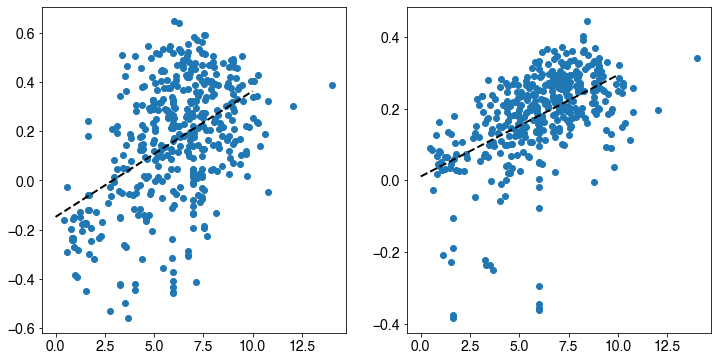

In [85]:
maize_yield_1d = maize_yield.reshape([maize_yield.size, 1])
maize_yield_deepak_trend_1d = maize_yield_deepak_trend.reshape([maize_yield_deepak_trend.size, 1])
yearly_txx_bias_trend_1d = yearly_txx_bias_trend.reshape([yearly_txx_bias_trend.size, 1])
cmip6_txx_bias_1d = cmip6_txx_bias.reshape([cmip6_txx_bias.size, 1])
cmip6_t50p_bias_1d = cmip6_t50p_bias.reshape([cmip6_t50p_bias.size, 1])

nn_txx = np.where((~np.isnan(maize_yield_1d)) & (~np.isnan(cmip6_txx_bias_1d)))[0]
nn_t50p = np.where((~np.isnan(maize_yield_1d)) & (~np.isnan(cmip6_t50p_bias_1d)))[0]

X = sm.add_constant(maize_yield_1d[nn_txx])
mdl_txx = sm.OLS(cmip6_txx_bias_1d[nn_txx], X).fit()

X = sm.add_constant(maize_yield_1d[nn_t50p])
mdl_t50p = sm.OLS(cmip6_t50p_bias_1d[nn_t50p], X).fit()

fig, ax = plt.subplots(1,2,figsize=(12,6))

x1 = 0
x2 = 10
ax[0].scatter(maize_yield_1d[nn_txx], cmip6_txx_bias_1d[nn_txx])
ax[0].plot([x1, x2], [mdl_txx.params[0]+x1*mdl_txx.params[1], mdl_txx.params[0]+x2*mdl_txx.params[1]], '--k', lw=2)

x1 = 0
x2 = 10
ax[1].scatter(maize_yield_1d[nn_t50p], cmip6_t50p_bias_1d[nn_t50p])
ax[1].plot([x1, x2], [mdl_t50p.params[0]+x1*mdl_t50p.params[1], mdl_t50p.params[0]+x2*mdl_t50p.params[1]], '--k', lw=2)

In [86]:
mdl_txx.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     114.3
Date:                Thu, 05 Nov 2020   Prob (F-statistic):           1.00e-23
Time:                        21:07:14   Log-Likelihood:                 33.064
No. Observations:                 417   AIC:                            -62.13
Df Residuals:                     415   BIC:                            -54.06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1482      0.031     -4.788      0.000      -0.209      -0.087
x1             0.0512      0.005     10.690      0.000       0.042       0.061
==============================================================================
Omnibus:                        8.254   Durbin-Watson:                   0.451
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                8.504
Skew:                          -0.347   Prob(JB):                       0.0142
Kurtosis:                       2.911   Cond. No.                         18.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

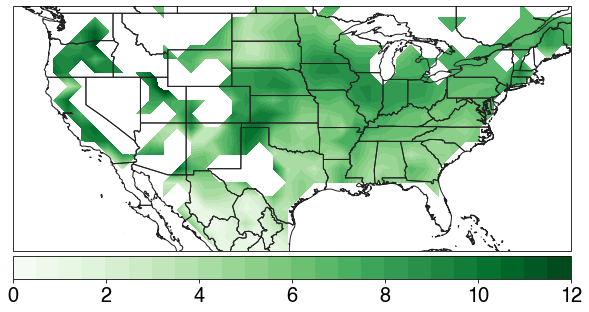

In [87]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-128, -67, 23, 46])

v1 = 0
v2 = 12.01
vstep = .5
vlabelstep = 2

midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
cmap = plt.cm.get_cmap('Greens')
c = plt.contourf(maize_yield_deepak_ds.lon, maize_yield_deepak_ds.lat, np.nanmean(maize_yield_deepak_ds.maize_yield.values, axis=0), cmap=cmap, norm=midnorm, levels=np.arange(v1,v2,vstep))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
# cb.set_label('Trend in T50p bias (CMIP6-ERA5)\n($\degree$C/decade, 1979-2015)', fontsize=20)